In [69]:
# ============================================================
# 1. IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
import yfinance as yf
from sklearn.preprocessing import LabelEncoder


In [84]:
# ============================================================
# 2. LOAD & IMPROVE LEXICONS FROM Loughran-McDonald
# ============================================================
lex = pd.read_csv("lexicons.csv")

# Clean 'Word' column
lex["Word"] = lex["Word"].astype(str).str.lower().str.strip()

# ---------------------------
# A. Strong sentiment words
# ---------------------------
positive_words = set(lex[lex["Positive"] > 0]["Word"])
negative_words = set(lex[lex["Negative"] > 0]["Word"])

# ---------------------------
# B. Add weak negative words from LM lexicon
#    (used heavily in financial sentiment)
# ---------------------------
weak_negative = set(lex[
    (lex["Uncertainty"] > 0) |
    (lex["Litigious"] > 0) |
    (lex["Strong_Modal"] > 0) |
    (lex["Constraining"] > 0)
]["Word"])

# Add weak negatives into negative_words with low weight later
negative_words = negative_words.union(weak_negative)

# ---------------------------
# C. Cleaned neutral list — we keep ONLY words
#    that are common in financial headlines
# ---------------------------
common_neutral_keep = {
    "report", "reports", "update", "statement", "says",
    "announces", "announcement", "reveals", "meeting",
    "press", "release", "coverage", "story", "interview"
}

# Build neutral set only from useful headline words
neutral_words = set()

for word in lex["Word"]:
    if word not in positive_words and word not in negative_words:
        if word in common_neutral_keep:
            neutral_words.add(word)

# ---------------------------
# Print sizes
# ---------------------------
print("Lexicon sizes AFTER FIX:")
print("Positive words:", len(positive_words))
print("Negative words:", len(negative_words))
print("Neutral words:", len(neutral_words))

Lexicon sizes AFTER FIX:
Positive words: 347
Negative words: 3516
Neutral words: 14


In [85]:
# ============================================================
# 5. LOAD HEADLINES DATA
# ============================================================
df = pd.read_csv("stock_news.csv")
df = df[["headline"]].dropna().reset_index(drop=True)

print("Total headlines:", len(df))

Total headlines: 26000


In [87]:
# ============================================================
# 4. TRAIN TEST SPLIT
# ============================================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, shuffle=True
)

In [88]:
# ============================================================
# 5. PREPROCESS
# ============================================================
train_df["clean"] = train_df["headline"].apply(clean_text_basic)
test_df["clean"]  = test_df["headline"].apply(clean_text_basic)

train_df["label_str"] = train_df["clean"].apply(label_with_score)
test_df["label_str"]  = test_df["clean"].apply(label_with_score)

In [89]:
# ============================================================
# 6. LABEL ENCODER
# ============================================================
encoder = LabelEncoder()
encoder.fit(["negative", "neutral", "positive"])

train_df["label"] = encoder.transform(train_df["label_str"])
test_df["label"]  = encoder.transform(test_df["label_str"])

print("Label mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [90]:
# ============================================================
# 7. TF-IDF VECTORIZATION
# ============================================================
vectorizer = TfidfVectorizer(max_features=25000, min_df=2)
X_train = vectorizer.fit_transform(train_df["clean"])
X_test  = vectorizer.transform(test_df["clean"])

y_train = train_df["label"]
y_test = test_df["label"]

In [91]:

# ============================================================
# 8. TRAIN MODEL
# ============================================================
model = MultinomialNB(alpha=0.5)
model.fit(X_train, y_train)

,alpha,0.5
,force_alpha,True
,fit_prior,True
,class_prior,None


In [92]:
# ============================================================
# 8. TEST MODEL
# ============================================================
preds = model.predict(X_test)
proba = model.predict_proba(X_test)

print("\n===== ACCURACY =====")
print("Accuracy:", accuracy_score(y_test, preds))

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_test, preds))



===== ACCURACY =====
Accuracy: 0.7663461538461539

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1513
           1       0.76      0.91      0.83      3040
           2       0.87      0.27      0.41       647

    accuracy                           0.77      5200
   macro avg       0.80      0.62      0.66      5200
weighted avg       0.78      0.77      0.75      5200



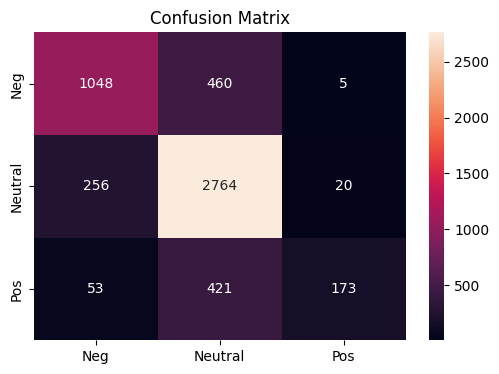

In [93]:
# ============================================================
# 9. CONFUSION MATRIX GRAPH
# ============================================================
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Neg", "Neutral", "Pos"],
            yticklabels=["Neg", "Neutral", "Pos"])
plt.title("Confusion Matrix")
plt.show()

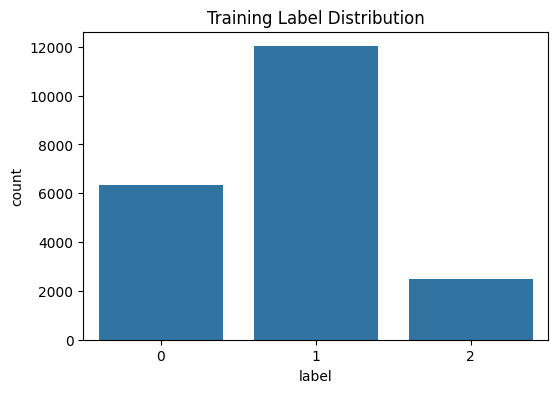

In [94]:
# ============================================================
# 10. LABEL DISTRIBUTION
# ============================================================
plt.figure(figsize=(6,4))
sns.countplot(x=train_df["label"])
plt.title("Training Label Distribution")
plt.show()

In [83]:
# ============================================================
# 11. DISPLAY SAMPLE OUTPUTS
# ============================================================
out = test_df.copy()
out["pred"] = preds
out["proba"] = list(proba)
display(out.head(5))

,headline,clean,label_str,label,pred,proba
4148,Applied Materials Gives Weak Forecast as Short...,applied materials gives weak forecast as short...,negative,0,0,"[0.9700023242991722, 0.02070247207310977, 0.00..."
7841,Rockwell Automation (ROK) Q2 Earnings & Sales ...,rockwell automation rok q earnings sales miss ...,negative,0,1,"[0.4774857473598343, 0.48979219230669946, 0.03..."
18898,CSX (CSX) Stock Sinks As Market Gains: What Yo...,csx csx stock sinks as market gains what you s...,positive,2,2,"[0.03231944850181456, 0.2602770491331357, 0.70..."
4194,5 Things About Take Two Interactive Smart Inve...,things about take two interactive smart invest...,neutral,1,1,"[0.07483626671682629, 0.8968039863793815, 0.02..."
8409,Pacific Coast Building Products buys $13 milli...,pacific coast building products buys million r...,negative,0,0,"[0.5770216894330014, 0.35523705253399357, 0.06..."


In [ ]:

# ============================================================
# 13. REAL-TIME YAHOO FINANCE HEADLINES (SAFE VERSION)
# ============================================================
def get_realtime_headlines(ticker="TSLA"):
    try:
        t = yf.Ticker(ticker)
        news = t.news or []
    except:
        return []

    headlines = []
    for item in news:
        title = item.get("title") or item.get("headline") or item.get("summary")
        if title and isinstance(title, str):
            headlines.append(title.strip())
    return headlines


def predict_headline_sentiment(text):
    clean = clean_text_basic(text)
    X = vectorizer.transform([clean])
    pred = model.predict(X)[0]
    proba = model.predict_proba(X)[0]

    label = encoder.inverse_transform([pred])[0]
    return label, proba


print("\n===== REAL-TIME YAHOO NEWS SENTIMENT =====")
tsla_news = get_realtime_headlines("TSLA")

if not tsla_news:
    print("No valid headlines found.")
else:
    for i, h in enumerate(tsla_news[:10], start=1):
        sentiment, p = predict_headline_sentiment(h)
        print(f"\n{i}. {h}")
        print(f"   Sentiment: {sentiment}")
        print(f"   Probabilities: [NEG={p[0]:.4f}, NEUTRAL={p[1]:.4f}, POS={p[2]:.4f}]")


===== REAL-TIME YAHOO NEWS SENTIMENT =====
No valid headlines found.
